In [ ]:
#Degrees of freedom: $\alpha,\theta$ 
#Intermediate angles:$\beta,\gamma$
#Lengths:$L_1,L_2,L_3,L_4$
#Linear Stiffnesses: $C_1,C_2,C_3,C_4$
#Rotational Stiffnesses: $K_f1,K_f2,K_f3,K_f4$
#intermediate displacements: $d_1,d_2,d_3,d_4$
#weighing stiffnesses $K_1,K_2,K_3$

In [1]:
import sympy as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib ipympl

#Define degrees of freedom, and initial values




In [61]:
class UnitCell:
    """
    A class representing a unit cell in the system.

    Attributes:
    - alpha (float): the angle of the left leg with respect to the vertical axis
    - theta (float): the angle of the right leg with respect to the vertical axis
    - params (dict): a dictionary containing the mechanism parameters
    - i (int): the index of the unit cell in the system
    - left_neighbor (UnitCell): the left neighbor of the unit cell
    - right_neighbor (UnitCell): the right neighbor of the unit cell
    - F_d_func (function): a function that computes the force residual in the left leg
    - F_b_func (function): a function that computes the force residual in the right leg
    - J_func (function): a function that computes the Jacobian matrix of the force residuals
    """
    def __init__(self, alpha_init, theta_init, params):
        self.alpha = alpha_init
        self.theta = theta_init
        self.params = params  
        self.i = 0  


        self.left_neighbor: UnitCell = None
        self.right_neighbor: UnitCell = None

        # Define the symbolic variables
        alpha_sym, theta_sym, u_sym = sm.symbols('alpha, theta, u')
        theta_prev_sym, theta_next_sym = sm.symbols('theta_prev, theta_next')

        # Define the symbolic expressions for F_d and F_b
        F_d_sym, F_b_sym, beta_sym, gamma_sym= self.define_force_residuals(
            alpha_sym, theta_sym, u_sym, theta_prev_sym, theta_next_sym, params)
        
        F = sm.Matrix([F_d_sym, F_b_sym])
        J = F.jacobian([alpha_sym, theta_sym])

        # Lambdify the expressions
        self.F_d_func = sm.lambdify(
            (alpha_sym, theta_sym, u_sym,theta_prev_sym, theta_next_sym), F_d_sym, {"DiracDelta": 0})
        self.F_b_func = sm.lambdify(
            (alpha_sym, theta_sym, u_sym,theta_prev_sym, theta_next_sym), F_b_sym, {"DiracDelta": 0})
        
        self.J_func = sm.lambdify(
            (alpha_sym, theta_sym, u_sym,theta_prev_sym, theta_next_sym), J, 'numpy')
        
        self.beta_func = sm.lambdify(
            (alpha_sym, theta_sym), beta_sym, 'numpy')
        self.gamma_func = sm.lambdify(
            (alpha_sym, theta_sym), gamma_sym, 'numpy')
    
    def update_state(self, alpha, theta):
        self.alpha = alpha
        self.theta = theta

    def define_force_residuals(self, alpha, theta, u, theta_prev, theta_next, params):
        # Implement the computation of force residuals F_d and F_b here
        # This should return symbolic expressions in terms of alpha, theta, and u
        alpha0, theta0 = sm.symbols('alpha0,theta0')
        beta0, gamma0 = sm.symbols('beta0,gamma0')
        # define constants
        L1, L2, L3, L4 = sm.symbols('L1,L2,L3,L4')
        C1, C2, C3, C4 = sm.symbols('C1,C2,C3,C4')
        Kf1, Kf2, Kf3, Kf4 = sm.symbols('Kf1,Kf2,Kf3,Kf4')
        K1, K2, K3 = sm.symbols('K1,K2,K3')
        d0 = L1*(sm.sin(alpha0) - sm.sin(alpha))
        d1 = 2*L1*(sm.cos(alpha) - sm.cos(alpha0))
        beta = sm.asin((L2*sm.sin(beta0)-d1)/L2)
        d2 = (L2*sm.sin(beta0)-d1)/(sm.tan(beta))-L2*sm.cos(beta0)
        gamma = sm.asin((L3*sm.sin(gamma0)-d1)/L3)
        d3 = (L3*sm.sin(gamma0)-d1)/(sm.tan(gamma))-L3*sm.cos(gamma0)
        L5 = (L4*sm.cos(theta0)-(L1*sm.cos(alpha0) +
              L3*sm.sin(gamma0)))/sm.cos(theta0)
        d4 = L5*(sm.sin(theta0)-sm.sin(theta))
        d5 = 2*L4*(sm.cos(theta) - sm.cos(theta0))+u
        d6 = L4*(sm.sin(theta0) - sm.sin(theta))
        d6_prev = L4*(sm.sin(theta0) - sm.sin(theta_prev))
        d6_next = L4*(sm.sin(theta0) - sm.sin(theta_next))


        K1_tog = sm.Heaviside(d6_prev-d0)
        K2_tog = sm.Heaviside(d6-d0)
        K3_tog = sm.Heaviside(d6_next-d0)


        # define the energy of the system
        E = 0.5*(8*Kf1*(alpha-alpha0)**2
                 + 8*Kf2*(beta-beta0)**2
                 + 2*Kf3*(gamma-gamma0)**2
                 + 8*Kf4*(theta-theta0)**2
                 + C1*(d2)**2
                 + C2*(d3)**2
                 + C3*(d4-d3)**2
                 + C4*(d5)**2
                 + K1*K1_tog*(d6_prev-d0)**2
                 + K2*K2_tog*(d6-d0)**2
                 + K3*K3_tog*(d6_next-d0)**2
                 )

        # define the force of the system
        F_d = -sm.diff(E, alpha)
        F_b = -sm.diff(E, theta)

        

        return F_d.subs(params), F_b.subs(params), beta.subs(params), gamma.subs(params)

    def compute_force_residuals(self, u):

        #check if the left and right neighbors exist
        if self.left_neighbor is None:
            left_neighbor_theta = 0
        else:
            left_neighbor_theta = self.left_neighbor.theta

        if self.right_neighbor is None:
            right_neighbor_theta = 0
        else:
            right_neighbor_theta = self.right_neighbor.theta
        # Evaluate the lambdified functions



        F_d = self.F_d_func(self.alpha, self.theta, u,left_neighbor_theta,right_neighbor_theta)
        F_b = self.F_b_func(self.alpha, self.theta, u,left_neighbor_theta,right_neighbor_theta)
        return F_d, F_b
    
    def compute_jacobian(self,u):
        # Implement the computation of the Jacobian matrix here
        if self.left_neighbor is None:
            left_neighbor_theta = 0
        else:
            left_neighbor_theta = self.left_neighbor.theta
        if self.right_neighbor is None:
            right_neighbor_theta = 0
        else:
            right_neighbor_theta = self.right_neighbor.theta

        J = self.J_func(self.alpha, self.theta, u,left_neighbor_theta,right_neighbor_theta)
        return J
    
    def compute_points(self):
        # Implement the computation of the points here
        # This should return a list of points (x, y) that can be used to plot the unit cell
        
        #calculate intermediate angles
        beta = self.beta_func(self.alpha, self.theta)
        gamma = self.gamma_func(self.alpha, self.theta)

        BE_DE_gap = self.params['L4']
        #L5 = (L4*sm.cos(theta0)-(L1*sm.cos(alpha0) +
        #      L3*sm.sin(gamma0)))/sm.cos(theta0)
        L5 = (self.params['L4']*np.cos(self.params['theta0'])-(self.params['L1']*np.cos(self.params['alpha0']) +
                self.params['L3']*np.sin(self.params['gamma0'])))/np.cos(self.params['theta0'])

        end_effector = np.array([-self.params['L1']*np.sin(self.alpha), self.params['L1']*np.cos(self.alpha)])
        bistable_shuttle = np.array([0,2*self.params['L1']*np.cos(self.alpha)])
        bistable_anchor = bistable_shuttle + np.array([self.params['L2']*np.cos(beta),self.params['L2']*np.sin(beta)])
        bistable_anchor2 = bistable_shuttle + np.array([-self.params['L2']*np.cos(beta),self.params['L2']*np.sin(beta)])
        signal_router = bistable_shuttle + np.array([self.params['L3']*np.cos(gamma),self.params['L3']*np.sin(gamma)])
        bifurcation_anchor = np.array([BE_DE_gap, self.params['L1']*np.cos(self.params['alpha0'])+self.params['L4']*np.cos(self.params['theta0'])])
        bifurcation_shuttle = bifurcation_anchor + np.array([-self.params['L4']*np.sin(self.theta),-self.params['L4']*np.cos(self.theta)])
        bifurcation_signal = bifurcation_anchor+np.array([-L5*np.sin(self.theta),-L5*np.cos(self.theta)])
        bifurcation_input = bifurcation_anchor+np.array([0,-2*self.params['L4']*np.cos(self.theta)])


        points = np.array([
            np.array([0, 0]), #origin
            end_effector, #end effector
            bistable_shuttle, #bistable shuttle
            bistable_anchor, #right bistable anchor
            bistable_shuttle, #bistable shuttle
            bistable_anchor2, #left bistable anchor
            bistable_shuttle, #bistable shuttle
            signal_router, #signal router
            bifurcation_signal, #bifurcation signal
            bifurcation_anchor, #bifurcation anchor
            bifurcation_shuttle, #bifurcation shuttle
            bifurcation_input, #bifurcation input
        ])
        return points

    def enforce_constraints(self):
        # Enforce the constraints for alpha here
        pass


class System:
    def __init__(self, unit_cells):
        self.unit_cells = unit_cells
        self.n = len(unit_cells)
        self.u = 0
        self.cell_spacing = 10e-3

        # Connect unit cells
        for i in range(self.n):
            if i > 0:
                unit_cells[i].left_neighbor = unit_cells[i - 1]
            if i < len(unit_cells) - 1:
                unit_cells[i].right_neighbor = unit_cells[i + 1]
            unit_cells[i].i = i

        self.state_vector = np.zeros(2*self.n)
        for i in range(self.n):
            self.state_vector[2*i] = self.unit_cells[i].alpha
            self.state_vector[2*i+1] = self.unit_cells[i].theta

    def update_state(self, state_vector):
        self.state_vector = state_vector
        for cell in self.unit_cells:
            cell.update_state(state_vector[2*cell.i], state_vector[2*cell.i+1])


    def compute_residuals(self, state_vector):
            """
            Computes the residuals of the system given the current state vector.

            Args:
            state_vector (numpy.ndarray): The current state vector.

            Returns:
            residuals (numpy.ndarray): The residuals of the system.
            """
            n = len(self.unit_cells)
            # Update state in each cell
            self.update_state(state_vector)

            # Compute residuals
            residuals = self.collect_force_residuals()

            return np.array(residuals)
    def collect_force_residuals(self):
        """
        Collects all force residuals across all unit cells.

        Returns:
        force_residuals (list): A list of all force residuals across all unit cells.
        """
        force_residuals = []
        for cell in self.unit_cells:
            F_d, F_b = cell.compute_force_residuals(self.u)
            force_residuals.append(F_d)
            force_residuals.append(F_b)
        return force_residuals
    
    def compute_jacobian(self, state_vector):
        n = len(self.unit_cells)
        # Update state in each cell
        self.update_state(state_vector)

        # Compute Jacobian
        jacobian = np.zeros((2*n, 2*n))
        for i in range(n):
            jacobian[2*i:2*(i+1), 2*i:2*(i+1)] = self.unit_cells[i].compute_jacobian(self.u)

        return jacobian

    def solve_equilibrium(self):
        """
        Solves the system of equations to find the equilibrium state of the unit cell.
        This method collects all force residuals and solves the system of equations using a suitable numerical method.
        """
        # Collect all force residuals
        roots = opt.root(self.compute_residuals, self.state_vector, jac=self.compute_jacobian)
        self.update_state(roots.x)

        # Solve the system of equations here using a suitable numerical method
        return roots.x

    def simulate(self, u_range):
        # Implement the simulation here.
        # This should iterate over all values of u in u_range, call solve_equilibrium,
        # and record the state of the system at each step
        for u in u_range:
            self.u = u
            self.state_vector = self.solve_equilibrium()
            #print(self.state_vector)

    def plot_system(self):
        plt.figure()
        ax = plt.axes(projection='3d')
        for cell in self.unit_cells:
            points = cell.compute_points()
            z_loc = cell.i*self.cell_spacing
            plt.plot(points[:, 0],z_loc*np.ones(points.shape[0]), points[:, 1],'k-o')
        ax.set_box_aspect((1,1,1))
        


def main():
    # Define mechanism parameters
    E = 2.2e9
    t = 0.5e-3
    b = 5e-3
    Lf1 = 6e-3
    Lf2 = 4e-3
    Lr1 = 35e-3
    Lr2 = 24e-3
    Lr3 = 10e-3
    Lr4 = 80e-3

    alpha0 = 22*np.pi/180
    beta0 = 8*np.pi/180
    gamma0 = 30*np.pi/180
    theta0 = 2*np.pi/180

    kf1 = E*t*b**3/12/Lf1
    kf2 = E*t*b**3/12/Lf2
    kf3 = E*t*b**3/12/Lf2
    kf4 = E*t*b**3/12/Lf1

    #todo fix these values
    C1 = E*t*b/Lr1 #bistable support stiffness
    C2 = E*t*b/Lr2 #signal routing guiding stiffness
    C3 = 0#E*t*b/Lr3 #signal routing stiffness
    C4 = E*t*b/Lr4 #bifurcation support stiffness

    #todo fix these values
    K1 = 0e6
    K2 = 0e6
    K3 = 0e6



    params = {

        'L1': Lr1+Lf1,
        'L2': Lr2+Lf2,
        'L3': Lr3+Lf2,
        'L4': Lr4+Lf1,
        'C1': C1,
        'C2': C2,
        'C3': C3,
        'C4': C4,
        'Kf1': kf1,
        'Kf2': kf2,
        'Kf3': kf3,
        'Kf4': kf4,
        'alpha0': alpha0,
        'beta0': beta0,
        'gamma0': gamma0,
        'theta0': theta0,
        'K1': K1,
        'K2': K2,
        'K3': K3
    } 

    initial_configuration = [(22*np.pi/180, 2*np.pi/180)]
    # Initialize system with initial configuration of alphas
    unit_cells = [UnitCell(alpha, theta, params)
                    for alpha, theta in initial_configuration]

    # Create system
    u = 0 # Input displacement

    system = System(unit_cells)


    # Simulate system
    u_start = 0
    u_end = 20e-3
    num_steps = 100
    u_range = np.linspace(u_start, u_end, num_steps)
    system.simulate(u_range)

    # Analyze results
    # ...


if __name__ == "__main__":
    main()


In [67]:
# Define mechanism parameters
E = 2.2e9 #Young's modulus
t = 0.4e-3 #thickness
b = 5e-3    #width
Lf1 = 6e-3 #length of the flexure on end effector, and bifurcation
Lf2 = 4e-3 #length of the flexure on signal routing and bistable beams
Lr1 = 35e-3 #length of the rigid link on end effector
Lr2 = 24e-3 #length of the rigid link on bistable beams
Lr3 = 35e-3 #length of the rigid link on signal routing
Lr4 = 80e-3 #length of the rigid link on bifurcation

Ls1 = 3e-3 #length of the support on bistable beams
ts1 = 2e-3 #thickness of the support on bistable beams

alpha0 = 22*np.pi/180 #initial angle of the end effector
beta0 = 8*np.pi/180 #initial angle of the bistable beams
gamma0 = 30*np.pi/180 #initial angle of the signal routing
theta0 = 2*np.pi/180 #initial angle of the bifurcation

kf1 = E*b*t**3/12/Lf1
kf2 = E*b*t**3/12/Lf2
kf3 = E*b*t**3/12/Lf2
kf4 = E*b*t**3/12/Lf1

C1 = E*b*ts1**3/Ls1**3*20 #bistable support stiffness
C2 = 2*E*b*t**3/Lr2**3 #signal routing guiding stiffness
C3 = 10*E*b*t**3/Lr3**3/6 #signal routing stiffness
C4 = E*b*t**3/Lr4 #bifurcation support stiffness

#todo fix these values

K1 = 0e6
K2 = 0e6
K3 = 0e6

params = {
    'L1': Lr1+Lf1,
    'L2': Lr2+Lf2,
    'L3': Lr3+Lf2,
    'L4': Lr4+Lf1,
    'C1': C1,
    'C2': C2,
    'C3': C3,
    'C4': C4,
    'Kf1': kf1,
    'Kf2': kf2,
    'Kf3': kf3,
    'Kf4': kf4,
    'alpha0': alpha0,
    'beta0': beta0,
    'gamma0': gamma0,
    'theta0': theta0,
    'K1': K1,
    'K2': K2,
    'K3': K3
} 





State = [-10.   2.]
Forces = [ 7.17907180e+00 -1.80366052e-03]
[-0.22554917  0.01965391]
State = [-12.92301572   1.12608583]


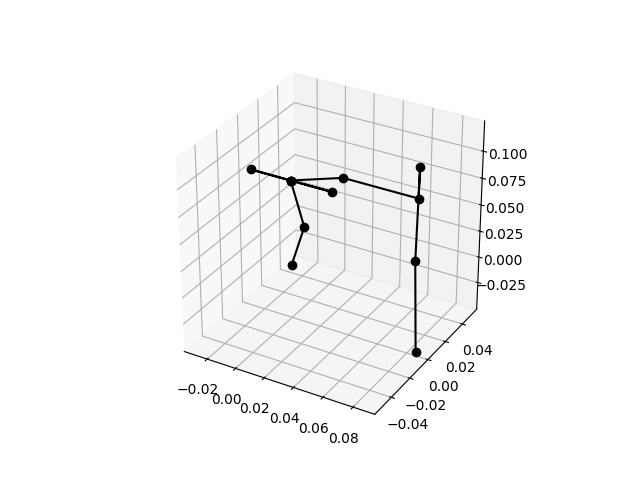

In [77]:
initial_configuration = [(-10*np.pi/180, 2*np.pi/180)]
# Initialize system with initial configuration of alphas
unit_cells = [UnitCell(alpha, theta, params) for alpha, theta in initial_configuration]

# Create system
u = 0 # Input displacement

system = System(unit_cells)
#print the state in degrees
print(f"State = {np.rad2deg(system.state_vector)}")
print(f"Forces = {system.compute_residuals(system.state_vector)}")
print(system.solve_equilibrium())
print(f"State = {np.rad2deg(system.state_vector)}")
system.plot_system()


In [49]:
system.compute_jacobian(system.state_vector)

array([[-1.21516466e+03,  1.37997024e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.37997024e-02, -2.08213756e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.21516466e+03,
         1.37997024e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.37997024e-02,
        -2.08213756e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.21516466e+03,  1.37997024e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.37997024e-02, -2.08213756e+00]])

[35.42475963 34.20939742]


0.9656917302261524

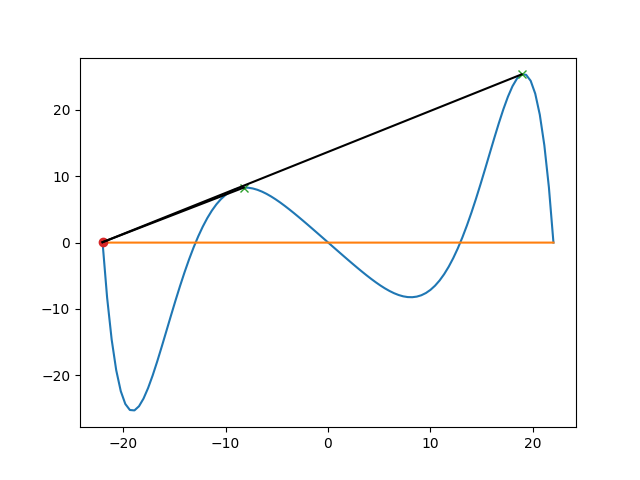

In [78]:
alphas = np.linspace(22,-22, 100)*np.pi/180
thetas = np.linspace(2,2, 100)*np.pi/180

state_vector = np.vstack((alphas,thetas)).T
state_vector.shape

residuals = np.zeros((100,2))
for i in range(100):
    residuals[i,:] = system.compute_residuals(state_vector[i,:])



import matplotlib.pyplot as plt
from scipy.signal import find_peaks

peaks, _ = find_peaks(residuals[:,0], height=0)
zero_crossings = np.where(np.diff(np.sign(residuals[:,0])))[0][-1]+1
plt.figure()
plt.plot(alphas*180/np.pi, residuals[:,0])
plt.plot(alphas*180/np.pi, residuals[:,1])
plt.plot(alphas[peaks]*180/np.pi, residuals[peaks,0], "x")
plt.plot(alphas[zero_crossings]*180/np.pi, residuals[zero_crossings,0], "o")

#draw lines between the zero crossings and the peaks
slopes = np.zeros(len(peaks))
for i in range(len(peaks)):
    plt.plot([alphas[peaks[i]]*180/np.pi, alphas[zero_crossings]*180/np.pi], [residuals[peaks[i],0], residuals[zero_crossings,0]], 'k-')
    #find slope of lines
    slope = (residuals[peaks[i],0]-residuals[zero_crossings,0])/(alphas[peaks[i]]-alphas[zero_crossings])
    slopes[i] = slope

print(slopes)

slopes[-1]/slopes[0]


0.028450404304001756
0.08600000000000001


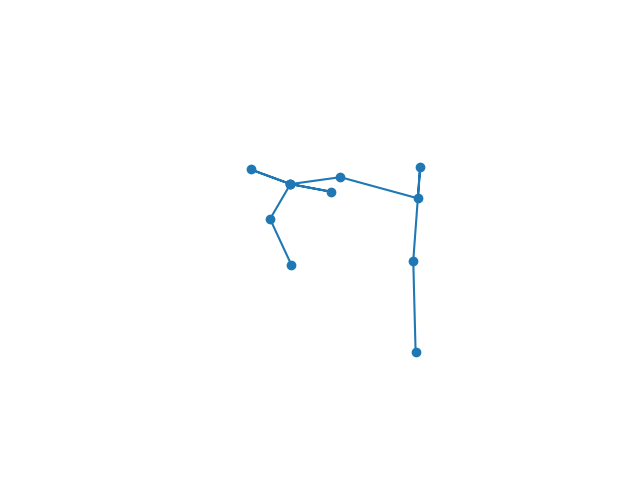

In [24]:
#print points of unit cell
plt.figure()
ax = plt.axes (projection ='3d')
points = unit_cells[0].compute_points()
plt.plot(points[:,0],np.zeros_like(points[:,0]),points[:,1], 'o-')
#set aspect ratio to 1,1,1


#get rid of the axes and the ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))






Todo:
-set coupling stiffness to zero, sweep alpha, plot residuals [Done]
-set correct coupling stiffnesses 
- extract other values from prbm (i.e. intermediate angles)
-implement optimisation algorithm [Done?]
-implement constraints handling: spring or optimisation constraints?
-visualise system

